# User Guide: Polydisperse Polymer Systems

**"How do I declare a molecular-weight distribution and sample a polydisperse chain ensemble in MolPy?"**

This guide demonstrates MolPy’s workflow from a **GBigSMILES** distribution declaration to a sampled chain ensemble, and then compares $M_n$ / $M_w$ / PDI against the theoretical distribution.

## What We Will Do

1. Declare four common distributions in GBigSMILES (Schulz–Zimm / Uniform / Poisson / Flory–Schulz)
2. Convert the parsed `DistributionIR` into a samplable distribution object (`create_polydisperse_from_ir`)
3. Sample a chain ensemble with `PolydisperseChainGenerator` + `SystemPlanner`
4. Compute $M_n$, $M_w$, and PDI from sampled chains and plot sample vs theory correctly (PMF vs PDF)

`SystemPlanner` (system level) repeatedly requests chains from `PolydisperseChainGenerator` (chain level) until the target total mass is met. The chain generator requests monomer sequences from a `SequenceGenerator` (sequence level).

## 1. Setup: Imports

We will use:

- **GBigSMILES parser**: parses a string into an IR (including distribution parameters)
- **Distribution factory**: `create_polydisperse_from_ir` (turns `DistributionIR` into a samplable distribution object)
- **Chain generator**: `PolydisperseChainGenerator` (samples DP or mass, then generates a chain)
- **System planner**: `SystemPlanner` (accumulates chain mass until the target mass is met)
- **Plotting**: Matplotlib

## Notes

This notebook is intentionally written as a single linear workflow (no `main()` function).
It focuses on:

- Parsing GBigSMILES with different polydisperse distributions
- Creating distribution objects via `create_polydisperse_from_ir`
- Sampling chains with `PolydisperseChainGenerator` + `SystemPlanner`
- Computing $M_n$ / $M_w$ / PDI and plotting sampled vs theoretical distributions

In [8]:
from random import Random

import matplotlib.pyplot as plt
import numpy as np

import molpy as mp
from molpy.builder.polymer.sequence_generator import WeightedSequenceGenerator
from molpy.builder.polymer.system import (
    FlorySchulzPolydisperse,
    PoissonPolydisperse,
    PolydisperseChainGenerator,
    SchulzZimmPolydisperse,
    SystemPlanner,
    UniformPolydisperse,
    create_polydisperse_from_ir,
 )
from molpy.core.element import Element

## 2. Declare distributions in GBigSMILES

We use a compact GBigSMILES form like:

- `{repeat_units}|distribution(params)|end_group|target_mass|`

Where:

- `repeat_units`: repeat unit set (can include multiple monomers)
- `distribution(params)`: distribution type and parameters
- `end_group`: end group (we use `[H].` as a simple example)
- `target_mass`: target total mass for the system (used by `SystemPlanner.target_total_mass`)

We compare four distributions:

1. **Schulz–Zimm** (continuous, mass space): `schulz_zimm(Mn, Mw)`
2. **Uniform** (discrete, DP space): `uniform(min_dp, max_dp)`
3. **Poisson** (discrete, DP space): `poisson(mean_dp)`
4. **Flory–Schulz** (discrete, DP space): `flory_schulz(a)`

**Checkpoint:** you can parse each string and find a `DistributionIR(name, params)` in the resulting IR.

In [9]:
def _build_distributions() -> list[dict]:
    """Configure the four distributions to test (GBigSMILES strings)."""
    return [
        {
            "name": "Schulz-Zimm",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|schulz_zimm(4800, 6000)|[H].|1e8|",
        },
        {
            "name": "Uniform",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|uniform(10,60)|[H].|1e8|",
        },
        {
            "name": "Poisson",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|poisson(30)|[H].|1e8|",
        },
        {
            "name": "Flory-Schulz",
            "gbigsmiles": "{[<]OCCOCCOCCOCCO[>],[<]OCC(c1ccccc1)CO[>]}|flory_schulz(0.06)|[H].|1e8|",
        },
    ]

## 3. Helpers: statistics and plotting

We do two small things:

1. Compute monomer mass from the parsed IR (needed to convert DP to chain mass)
2. Annotate each subplot with $M_n$, $M_w$, PDI, and number of sampled chains $N$

**Important:** Schulz–Zimm is a continuous distribution in mass space (PDF). The other three are discrete distributions in DP space (PMF). We overlay histogram vs PDF/PMF accordingly to avoid unit mismatches.

In [10]:
# --- helper: add ACS-style stats box at top-right of each axis ---
def annotate_stats(ax, Mn: float, Mw: float, PDI: float, n_chains: int) -> None:
    # if max(Mn, Mw) >= 1e4:
    #     Mn_txt = f"{Mn/1e3:.2f}\\,\\mathrm{{kDa}}"
    #     Mw_txt = f"{Mw/1e3:.2f}\\,\\mathrm{{kDa}}"
    # else:
    Mn_txt = f"{Mn:.0f}\\,\\mathrm{{g/mol}}"
    Mw_txt = f"{Mw:.0f}\\,\\mathrm{{g/mol}}"

    txt = (
        rf"$M_n={Mn_txt}$" "\n"
        rf"$M_w={Mw_txt}$" "\n"
        rf"$\mathrm{{PDI}}={PDI:.3f}$" "\n"
        rf"$N={n_chains}$"
    )
    ax.text(
        0.96, 0.96, txt,
        transform=ax.transAxes,
        ha="right", va="top",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.90),
    )

## 4. Run the workflow: sample and compute $M_n$ / $M_w$ / PDI

For each distribution, we run the same pipeline:

1. Parse the GBigSMILES string (repeat units + `DistributionIR`)
2. Create a samplable distribution via `create_polydisperse_from_ir` (supports `sample_dp` or `sample_mass`)
3. Build a `WeightedSequenceGenerator` (sequence layer)
4. Build a `PolydisperseChainGenerator` (chain layer: sample DP/mass → generate one chain)
5. Build a `SystemPlanner` (system layer: keep sampling until the target mass is met)
6. Compute sampled-chain $M_n$ / $M_w$ / PDI
7. Plot: sampled histogram vs theoretical PMF/PDF

**Checkpoint:** you see 4 subplots (one per distribution), each with a reasonable fit overlay and finite $M_n$ / $M_w$ / PDI.

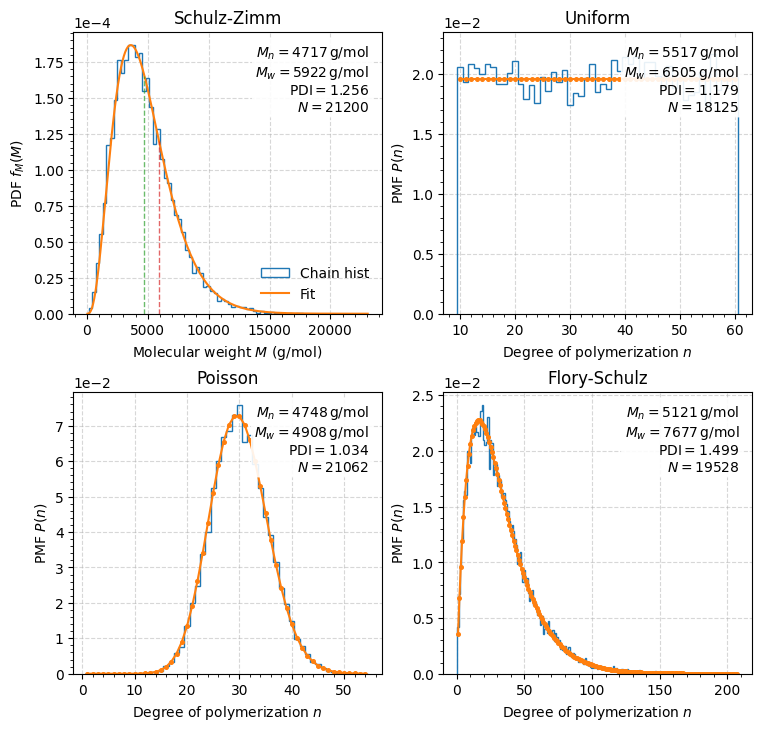

In [ ]:
# Run the end-to-end workflow (no main())
distributions_to_test = _build_distributions()
random_seed = 43

results: list[dict] = []

for dist_config in distributions_to_test:
    ir = mp.parser.parse_gbigsmiles(dist_config["gbigsmiles"])

    component_ir = ir.molecules[0]
    mol_ir = component_ir.molecule
    target_mass = component_ir.target_mass

    repeat_units = mol_ir.structure.stochastic_objects[0].repeat_units
    monomers = [unit.graph for unit in repeat_units]
    monomer_masses_list = [_monomer_mass(m) for m in monomers]

    weights_dict = {str(i): 1.0 for i in range(len(monomers))}

    distribution_ir = None
    for meta in mol_ir.stochastic_metadata:
        if meta.distribution:
            distribution_ir = meta.distribution
            break
    if distribution_ir is None:
        raise ValueError(f"No distribution IR found for {dist_config['name']}")

    dist_obj = create_polydisperse_from_ir(distribution_ir, random_seed=random_seed)

    results.append(
        {
            "name": dist_config["name"],
            "dist_obj": dist_obj,
            "weights": weights_dict,
            "monomer_masses": {str(i): m for i, m in enumerate(monomer_masses_list)},
            "target_mass": float(target_mass) if target_mass is not None else None,
        }
    )

# Sample chains from each distribution
for result in results:
    seq_gen = WeightedSequenceGenerator(monomer_weights=result["weights"])
    chain_gen = PolydisperseChainGenerator(
        seq_generator=seq_gen,
        monomer_mass=result["monomer_masses"],
        end_group_mass=0.0,
        distribution=result["dist_obj"],
    )

    target_mass = result.get("target_mass", None)
    rng = Random(random_seed)
    planner = SystemPlanner(
        chain_generator=chain_gen,
        target_total_mass=target_mass if target_mass is not None else 1e7,
        max_rel_error=0.02,
    )
    system_plan = planner.plan_system(rng)
    chains = system_plan.chains

    result["molecular_weights"] = [chain.mass for chain in chains]
    result["dps"] = [chain.dp for chain in chains]
    result["n_chains"] = len(chains)

# Compute Mn, Mw, PDI from sampled chains
for result in results:
    mw_array = np.array(result["molecular_weights"], dtype=float)
    Mn = float(np.mean(mw_array))
    Mw = float(np.sum(mw_array**2) / np.sum(mw_array))
    PDI = Mw / Mn

    result["Mn"] = Mn
    result["Mw"] = Mw
    result["PDI"] = PDI

# Plot: sampled histogram vs theoretical PMF/PDF
fig, axes = plt.subplots(
    2, 2,
    figsize=(7.5, 7.2),
    constrained_layout=True,
    sharex=False,
    sharey=False,
)
axes = axes.flatten()

for idx, (ax, result) in enumerate(zip(axes, results)):
    dist_obj = result["dist_obj"]

    if isinstance(dist_obj, SchulzZimmPolydisperse):
        bins = 60
        histtype = "step"
        n_grid = 700
        x_pad_lo, x_pad_hi = 0.3, 1.3

        mw = np.asarray(result["molecular_weights"], dtype=float)
        ax.hist(mw, bins=bins, density=True, histtype=histtype, label="Chain hist" if idx == 0 else "")

        M_min = max(0.0, mw.min() * x_pad_lo)
        M_max = mw.max() * x_pad_hi
        M_grid = np.linspace(M_min, M_max, n_grid)
        pdf = dist_obj.mass_pdf(M_grid)
        ax.plot(M_grid, pdf, "-", label="Fit" if idx == 0 else "")

        Mn_val = result["Mn"]
        Mw_val = result["Mw"]
        ax.plot([Mn_val, Mn_val], [0, float(dist_obj.mass_pdf(Mn_val))], color="C2", linestyle="--", linewidth=1.0, alpha=0.7)
        ax.plot([Mw_val, Mw_val], [0, float(dist_obj.mass_pdf(Mw_val))], color="C3", linestyle="--", linewidth=1.0, alpha=0.7)

        ax.set_xlabel(r"Molecular weight $M$ (g/mol)")
        ax.set_ylabel(r"PDF $f_M(M)$")
        ax.grid(True, linestyle="--", alpha=0.5)

    elif isinstance(dist_obj, UniformPolydisperse):
        dp = np.asarray(result["dps"], dtype=int)
        dp_min, dp_max = int(dp.min()), int(dp.max())
        bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 1.0)
        ax.hist(dp, bins=bins_edges, density=True, histtype="step", label="Chain hist" if idx == 0 else "")

        support = np.arange(dp_min, dp_max + 1)
        pmf = dist_obj.dp_pmf(support)
        ax.plot(support, pmf, "-", marker="o", markersize=2.6, label="Fit" if idx == 0 else "")

        ax.set_xlabel(r"Degree of polymerization $n$")
        ax.set_ylabel(r"PMF $P(n)$")
        ax.grid(True, linestyle="--", alpha=0.5)
        ax.set_ylim(0, pmf.max() * 1.5)

    elif isinstance(dist_obj, PoissonPolydisperse):
        dp = np.asarray(result["dps"], dtype=int)
        dp_min, dp_max = int(dp.min()), int(dp.max())
        bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 1.0)
        ax.hist(dp, bins=bins_edges, density=True, histtype="step", label="Chain hist" if idx == 0 else "")

        theory_min = 1
        theory_max = max(dp_max, int(dp.mean() + 4 * dp.std()))
        support = np.arange(theory_min, theory_max + 1)
        pmf = dist_obj.dp_pmf(support)
        ax.plot(support, pmf, "-", marker="o", markersize=2.6, label="Fit" if idx == 0 else "")

        ax.set_xlabel(r"Degree of polymerization $n$")
        ax.set_ylabel(r"PMF $P(n)$")
        ax.grid(True, linestyle="--", alpha=0.5)

    elif isinstance(dist_obj, FlorySchulzPolydisperse):
        dp = np.asarray(result["dps"], dtype=int)
        dp_min, dp_max = int(dp.min()), int(dp.max())
        bins_edges = np.arange(dp_min - 0.5, dp_max + 1.5, 1.0)
        ax.hist(dp, bins=bins_edges, density=True, histtype="step", label="Chain hist" if idx == 0 else "")

        theory_min = 1
        theory_max = max(dp_max, int(dp.mean() + 4 * dp.std()))
        support = np.arange(theory_min, theory_max + 1)
        pmf = dist_obj.dp_pmf(support)
        ax.plot(support, pmf, "-", marker="o", markersize=2.6, label="Fit" if idx == 0 else "")

        ax.set_xlabel(r"Degree of polymerization $n$")
        ax.set_ylabel(r"PMF $P(n)$")
        ax.grid(True, linestyle="--", alpha=0.5)
        
    else:
        raise TypeError(f"Unsupported distribution type: {type(dist_obj)}")

    ax.set_title(result["name"])
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    annotate_stats(ax, result["Mn"], result["Mw"], result["PDI"], result["n_chains"])
    ax.minorticks_on()
    if idx == 0:
        ax.legend(frameon=False, loc="best")

plt.show()

## 5. Interpret the results

- **PDF vs PMF**: use `mass_pdf(M)` for continuous mass distributions (Schulz–Zimm), and `dp_pmf(n)` for discrete DP distributions (Uniform/Poisson/Flory–Schulz). Do not overlay a PMF on a PDF (different units).
- **Target total mass**: a large `target_mass` generates many chains. For quick smoke tests, reduce the `target_total_mass` or use a smaller value in the GBigSMILES string.
- **Reproducibility**: this example fixes both the distribution `random_seed` and the Python `Random(...)` seed so runs are repeatable.

## 6. Extensions

- **Turn a system plan into an atomistic structure**: feed `SystemPlan.chains` into a `PolymerBuilder` (atomistic build layer), then pack with Packmol to create an initial configuration.
- **Fit to experimental distributions**: implement a custom distribution that provides `mass_pdf/sample_mass` and plug it into the same pipeline.
- **Control copolymer composition**: adjust `WeightedSequenceGenerator` weights to change the repeat-unit composition.

## 7. Summary and next steps

You now have the standard path for generating a polydisperse polymer **system plan** with MolPy:

- `parse_gbigsmiles` parses repeat units and `DistributionIR` from a GBigSMILES string
- `create_polydisperse_from_ir` turns `DistributionIR` into a samplable distribution (DP space or mass space)
- `PolydisperseChainGenerator` samples chain size and generates sequences + chain mass
- `SystemPlanner` accumulates chains until the target total mass is reached
- Finally, compute $M_n$ / $M_w$ / PDI from the sampled chains and visualize histogram vs theoretical PMF/PDF

To convert this chain plan into an atomistic system suitable for LAMMPS, continue with the atomistic build + packing guides.